In [4]:
import torch

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from os.path import join

# Save output NetCDF as merged_not_tf.nc

In [14]:
merged_fp = join(r'/home/leroy/flexpart/paper/well_mixed_time_step/runs/hill_well_mixed_ts_1/flex_out', 'merged.nc')
topo_fp = join(r'/mnt/temp/Projects/MAPM/Data_Keep/Flexpart_PALM/shaun/', 'tunnel_smooth_topo_static.nc')
header_fp = join(r'/home/leroy/flexpart/paper/well_mixed_time_step/runs/hill_well_mixed_ts_1/flex_out', 'header_d01.nc')

In [15]:
merged = xr.open_dataset(merged_fp)
topo = xr.open_dataset(topo_fp)
header = xr.open_dataset(header_fp)

In [16]:
a = torch.from_numpy(topo['zt'].values)

In [17]:
a.shape

torch.Size([128, 256])

In [18]:
topo_interp = torch.nn.functional.avg_pool2d(torch.from_numpy(topo['zt'].values)[None], 4, 4).numpy()[0]

In [19]:
topo_interp.shape

(32, 64)

In [20]:
data = merged['CONC'].values
new = np.full_like(merged['CONC'].values, np.nan)
for n, hgt in enumerate(header['ZTOP'].values):
    mask = topo_interp <= hgt
    new[:, :, :, :, n:n+1 , mask] = data[:, :, :, :, n:n+1 , mask]

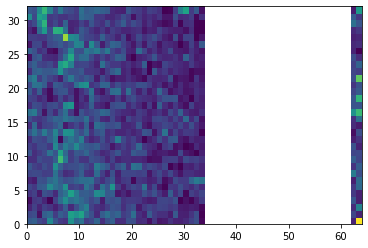

In [21]:
plt.pcolormesh(new[50, 0, 0, 0 ,5 ])

In [22]:
merged['CONC']

<xarray.DataArray 'CONC' (record: 142, Time: 1, ageclass: 1, species: 1, bottom_top: 39, south_north: 32, west_east: 64)>
array([[[[[[[  932.8315, ...,     0.    ],
            ...,
            [ 3938.6228, ..., 12437.758 ]],

           ...,

           [[ 2453.374 , ...,  6542.3296],
            ...,
            [    0.    , ...,  6542.3325]]]]]],





       ...,





       [[[[[[23320.76  , ..., 63432.41  ],
            ...,
            [ 2487.5518, ...,  6633.4707]],

           ...,

           [[ 2453.374 , ...,  6542.3296],
            ...,
            [    0.    , ...,  6542.3325]]]]]]], dtype=float32)
Dimensions without coordinates: record, Time, ageclass, species, bottom_top, south_north, west_east
Attributes:
    description:  CONCENTRATION OF AIRBORNE SPECIES
    coordinates:  XLONG XLAT
    units:        ng m-3

In [24]:
outdir = join(r'/home/leroy/flexpart/paper/well_mixed_time_step/runs/hill_well_mixed_ts_1/flex_out', 'merged_not_tf.nc')
da = xr.DataArray(data=new,
                  dims=["record", "Time", "ageclass", "species", "bottom_top", "south_north", "west_east"],
                  attrs=dict(description="CONCENTRATION OF AIRBORNE SPECIES",
                             coordinates= "XLONG XLAT",
                             units="ng m-3",),)

da.to_netcdf(outdir)